# Simulação da Transmissão de uma Onda Quadrada por Canais Passa-Baixas

O objetivo deste notebook é simular o que ocorre quando tentamos transmitir um certo sinal por canais com características de um passa-baixas. No nosso exemplo, vamos considerar, para fins de ilustração, um sinal emitido com a forma de uma onda **quadrada**. A partir daí, vamos tentar entender como seria o sinal efetivamente recebido na outra ponta dos nossos canais, devido única e exclusivamente aos efeitos deles sobre o sinal enviado.

Primeiramente, vamos importar as bibliotecas que serão úteis para nós:

In [1]:
#Importação das bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from scipy import signal
mpl.rcParams['figure.max_open_warning'] = False

## Geração do Sinal Emitido

Agora, vamos gerar um sinal com a forma de uma onda quadrada. Para isso, vamos gerar um vetor t com instantes de tempo linearmente espaçados entre os instantes $t_i$ (instante de tempo inicial da nossa simulação) e $t_f$ (instante de tempo final da nossa simulação). Em seguida, utilizando o módulo signal da biblioteca scipy, vamos gerar o nosso sinal que será aplicado na entrada do canal de comunicações, considerando uma frequência fundamental de $f_0 = 1$ Hz:

In [2]:
t_i = -3
t_f = 3
passo = 0.00001
t = -np.arange(t_i,t_f,passo)

dc = 0.5

f0 = 1

x = signal.square(2*np.pi*f0*t)

Na célula abaixo, estamos gerando um gráfico do sinal emitido ao longo do tempo:

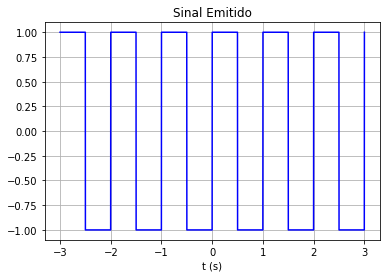

In [3]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
plt.plot(t, x,'-b')
plt.title('Sinal Emitido')
plt.xlabel('t (s)')
plt.grid()

## Canais de Comunicações

A seguir, vamos especificar o comportamento dos nossos canais de comunicações considerados nesta simulação. Nela, vamos simular os efeitos um canal passa-baixas de primeira ordem, cujo módulo da resposta em frequência será dado por $$H(f) = \dfrac{1}{\sqrt{1 + \left(\dfrac{f}{f_c}\right)^2}},$$ em que $f_c$ é a frequência de corte do nosso canal. Já a fase da resposta em frequência do nosso canal será dada por $$\varphi(f) = -\arctan\left(\dfrac{f}{f_c}\right).$$ Note que, quanto maior o valor da frequência $f$, menor o valor de $H(f)$, o que significa que frequências muito altas serão fortemente atenuadas, pois suas amplitudes serão multiplicadas por um número próximo de zero. Em contrapartida, para frequências baixas, o valor de $H(f)$ será próximo de 1, o que indica que a amplitude dessas ondas praticamente não será afetada pelo canal.

Para facilitar, vamos implementar o cálculo de $H(f)$ por meio de uma função, como ilustrado abaixo:

In [4]:
def modulo_resposta_em_frequencia(f,f_c):
    H = 1./np.sqrt(1+(f/f_c)**2)
    return H

Similarmente, podemos implementar o cálculo de $\varphi(f)$ como mostrado a seguir:

In [5]:
def fase_resposta_em_frequencia(f,f_c):
    Phi = np.arctan(-f/f_c)
    return Phi

Vamos agora gerar os gráficos da resposta em frequência dos canais de comunicações. Para isso, vamos criar um vetor de frequências, calcular o módulo e a fase da resposta em frequência para cada ponto, e plotar os resultados.

In [6]:
f_final = 50
f = np.arange(0,f_final,0.001)

A resposta em frequência vai variar com o valor da frequência de corte selecionada. Vamos adotar, por exemplo, $f_c = 2$ Hz e analisar os gráficos.

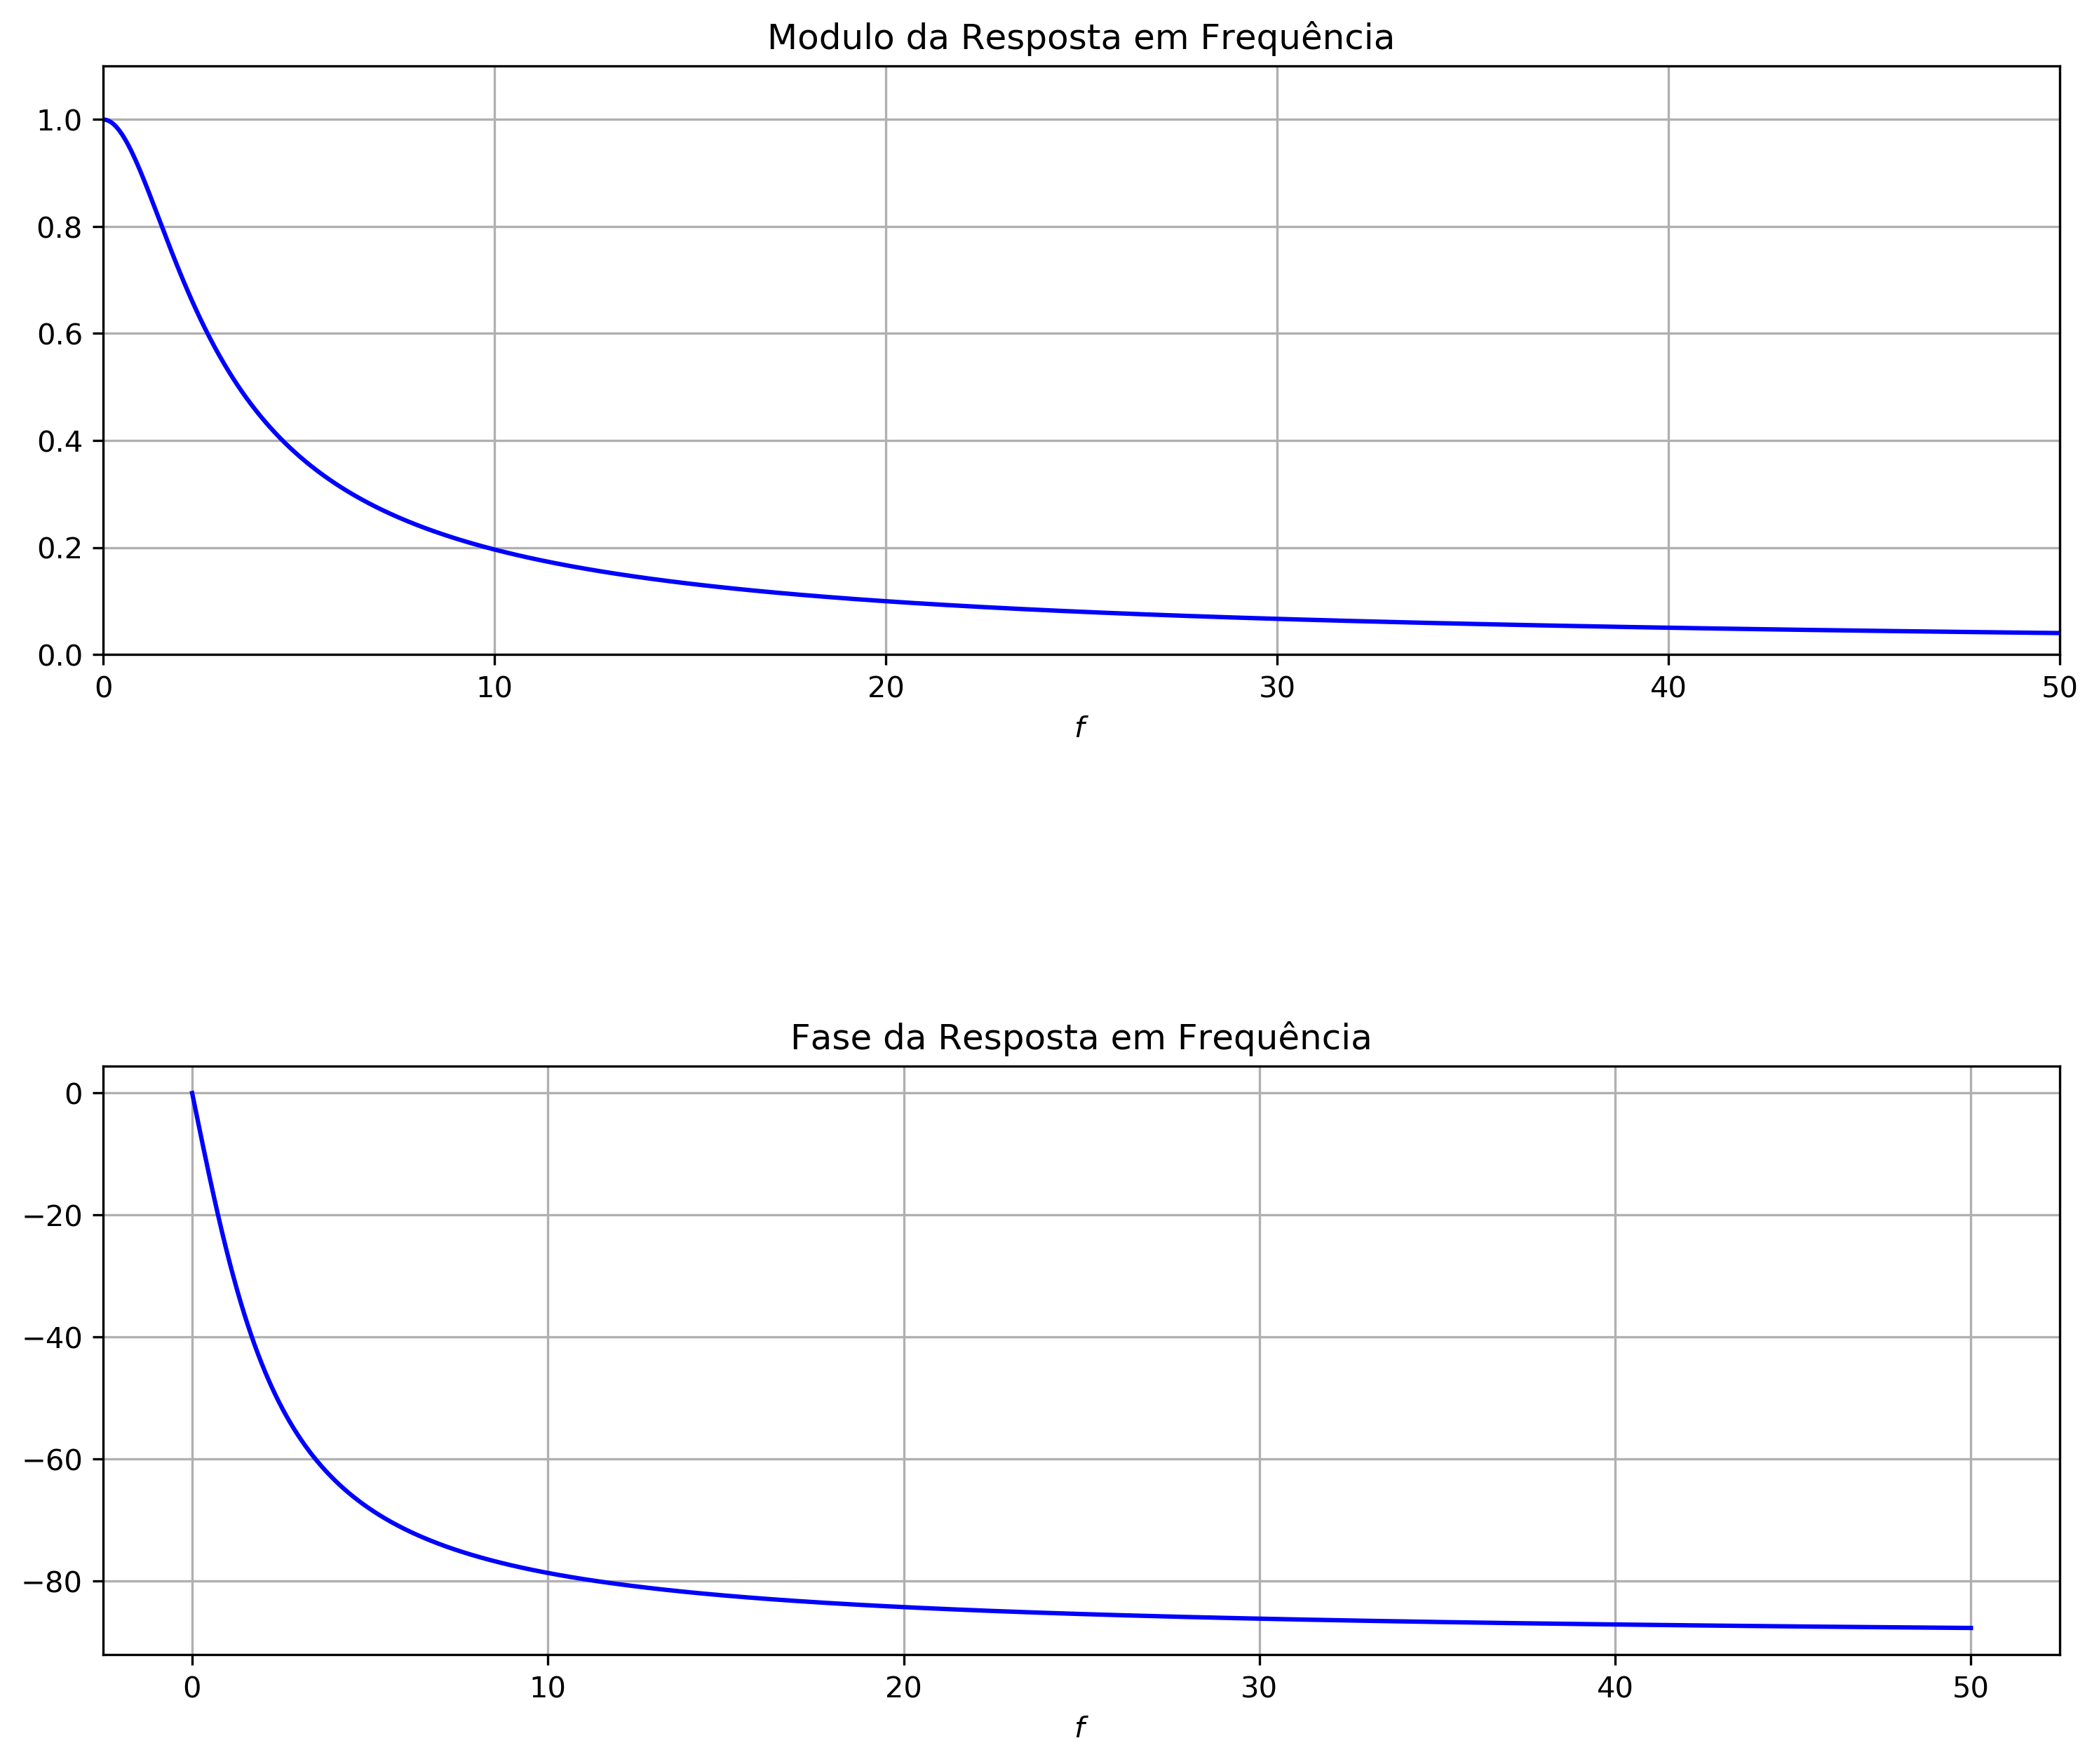

In [7]:
fc = 2


fig = plt.figure(figsize=(12,10), dpi= 300)
ax1 = fig.add_subplot(2, 1, 1)
#Gráfico do Módulo da Resposta em Frequência:
plt.plot(f, modulo_resposta_em_frequencia(f,fc),'-b')
plt.title('Modulo da Resposta em Frequência')
plt.xlabel(r'$f$')
plt.axis([0, f_final, 0.0, 1.1])
plt.grid()
#Gráfico da Fase da Resposta em Frequência (em graus):
ax2 = fig.add_subplot(2, 1, 2)
plt.plot(f, (180/np.pi)*fase_resposta_em_frequencia(f,fc),'-b')
plt.title('Fase da Resposta em Frequência')
plt.xlabel(r'$f$')
plt.grid()
fig.subplots_adjust(hspace=0.7)

**Note que este NÃO é um canal passa-baixas IDEAL!** O módulo da resposta em frequência não é 1 para frequências menores que 2 Hz, nem 0 para frequências acima desse valor. Lembre-se que, na prática, canais passa-baixa ou passa-faixa *ideais* não existem.

Se aumentarmos o valor da frequência de corte para $f_c = 20$ Hz e plotarmos novamente os gráficos, obteremos:

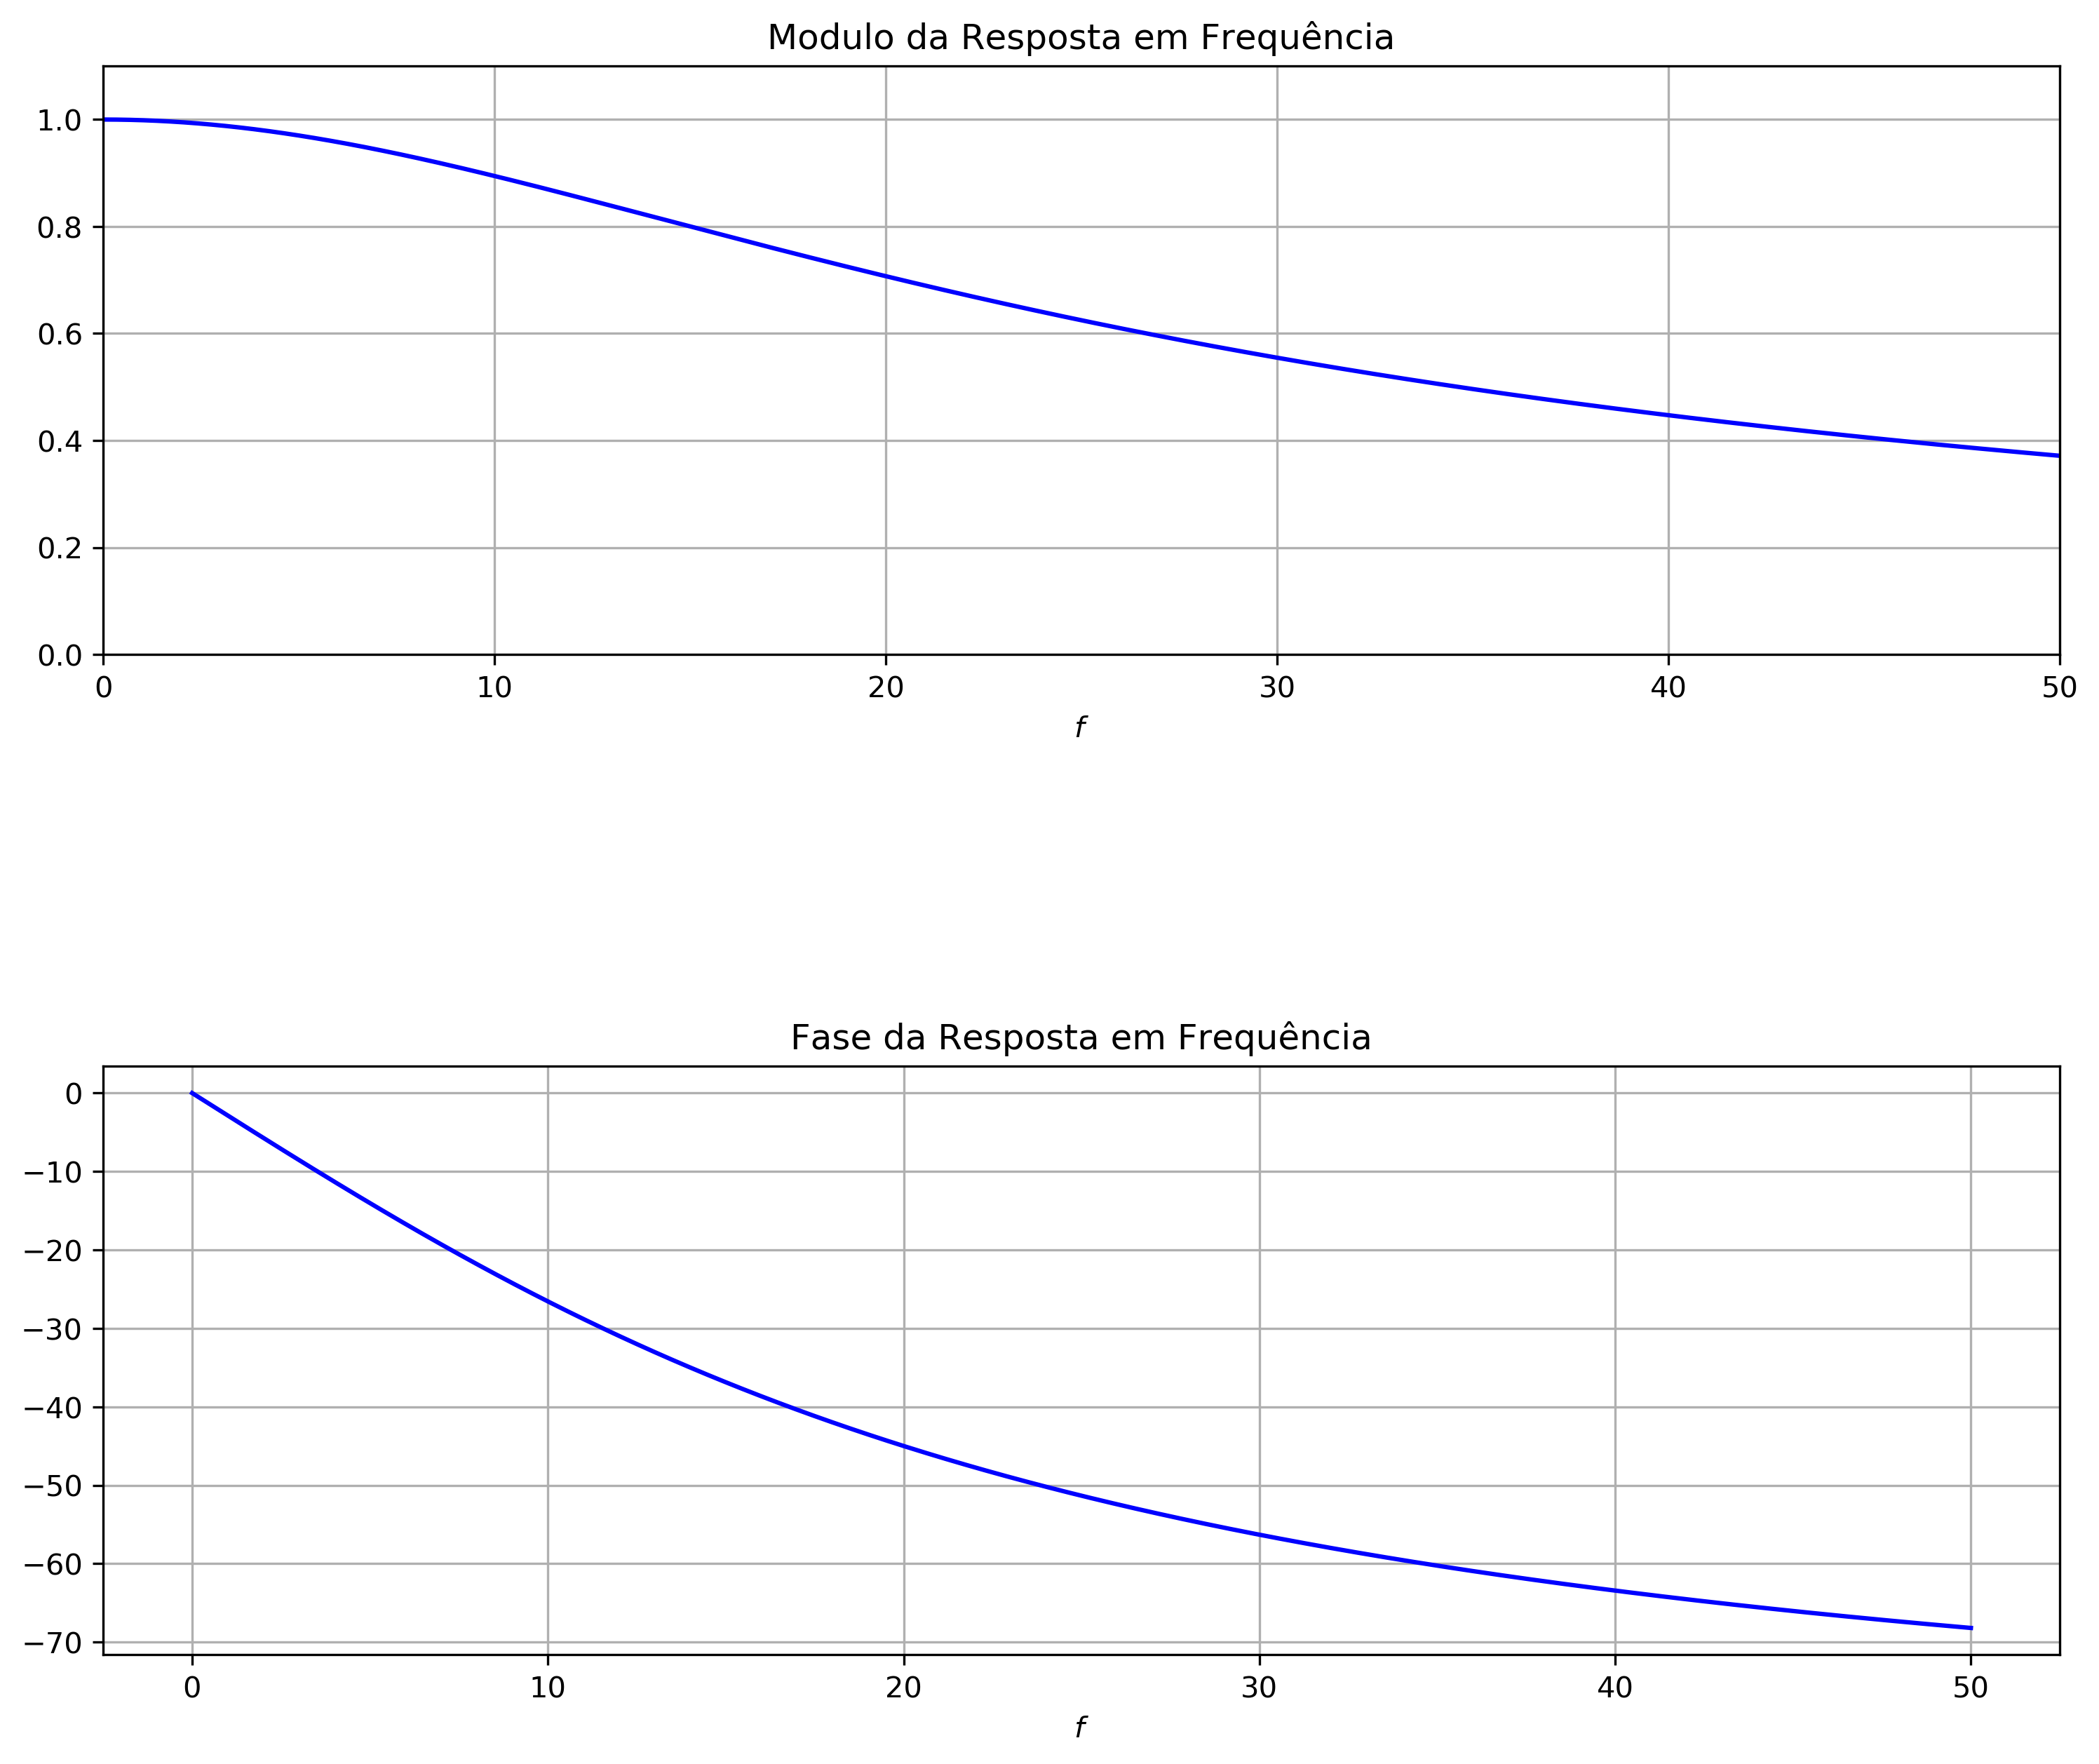

In [8]:
fc = 20


fig = plt.figure(figsize=(12,10), dpi= 300)
ax1 = fig.add_subplot(2, 1, 1)
#Gráfico do Módulo da Resposta em Frequência:
plt.plot(f, modulo_resposta_em_frequencia(f,fc),'-b')
plt.title('Modulo da Resposta em Frequência')
plt.xlabel(r'$f$')
plt.axis([0, f_final, 0.0, 1.1])
plt.grid()
#Gráfico da Fase da Resposta em Frequência (em graus):
ax2 = fig.add_subplot(2, 1, 2)
plt.plot(f, (180/np.pi)*fase_resposta_em_frequencia(f,fc),'-b')
plt.title('Fase da Resposta em Frequência')
plt.xlabel(r'$f$')
plt.grid()
fig.subplots_adjust(hspace=0.7)

Comparando os gráficos obtidos com $f_c = 2$ e com $f_c = 20$, vemos que, no segundo caso, a atenuação das frequências mais altas no gráfico é bem menos intensa do que quando tínhamos adotado $f_c = 2$.

### Diante disso, a pergunta que fica é: se tentarmos transmitir o nosso sinal em formato de dente-de-serra plotado anteriormente por esses canais, como ficará o sinal recebido na outra ponta?

Para responder a essa pergunta, vamos recorrer à Análise de Fourier. De posse da resposta em frequência dos canais, conseguimos saber como eles reagem à aplicação de ondas senoidais de diferentes frequências. Precisamos agora entender quais ondas senoidais fazem parte da composição do nosso sinal, e com que amplitudes e fases.

Como o sinal é periódico, sabemos que ele pode ser decomposto por meio da Série de Fourier, em que aparecerão uma componente constante e ondas cujas frequências são múltiplas inteiras da frequência fundamental $f_0$, ou seja, ondas com frequência $f_n = n \cdot f_0$, com $n = 1, 2, 3, \cdots$. Para essa a forma de onda do sinal plotado anteriormente, é possível obter: $$a_0 = 0,\quad A_n = \begin{cases}\dfrac{4}{\pi n},\ \text{se} \ n\ \text{for ímpar},\\ 0, \ \text{se}\ n\ \text{for par} \end{cases}\quad \text{e}\quad \phi_n = \begin{cases}-90^{\circ}\ \text{se} \ n\ \text{for ímpar},\\ \text{indefinido, se}\ n\ \text{for par} \end{cases}.$$ Para verificar isso, vamos comparar o sinal com a sua decomposição até a $n$-ésima harmônica, com $n$ indo de $1$ até $50$. Obs.: para as harmônicas pares ($n$ par), vamos atribuir uma fase de $0^\circ$.

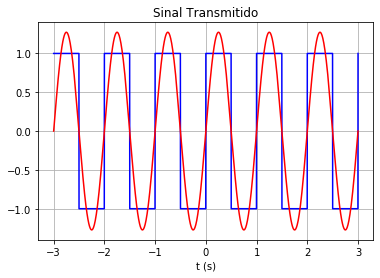

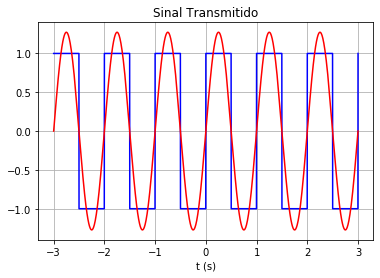

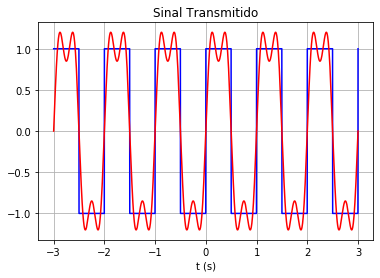

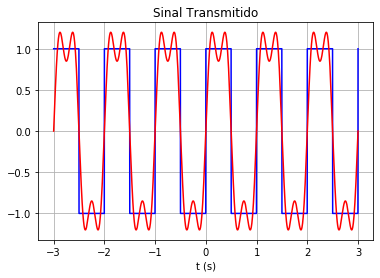

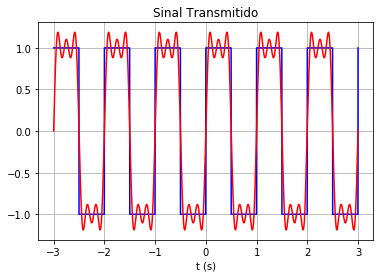

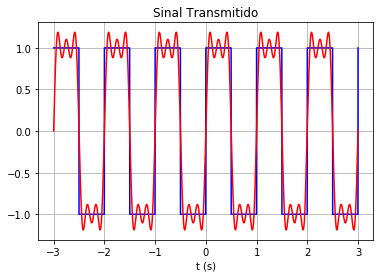

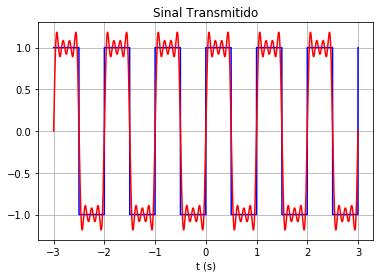

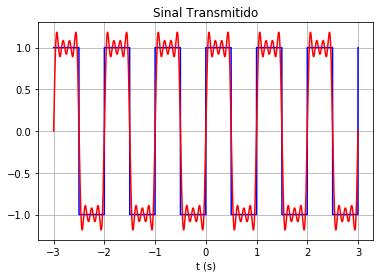

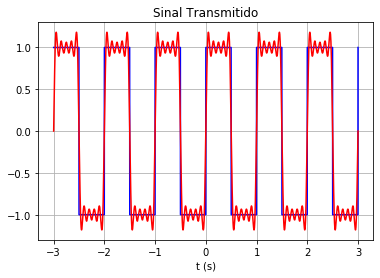

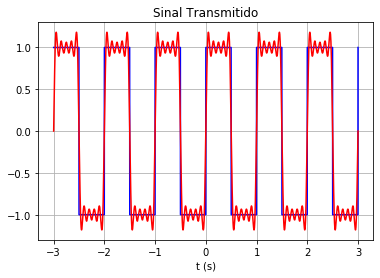

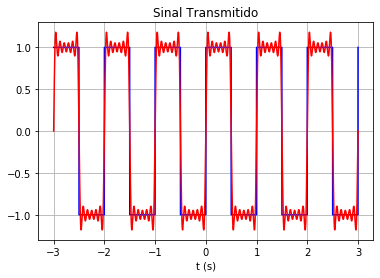

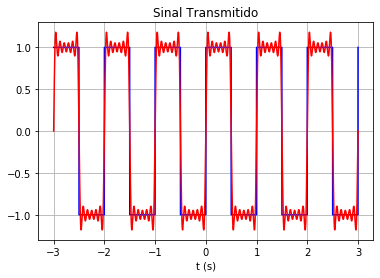

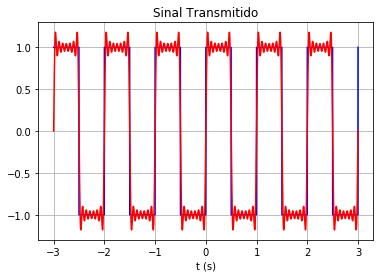

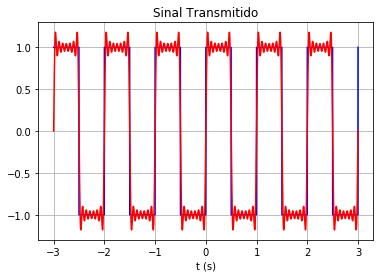

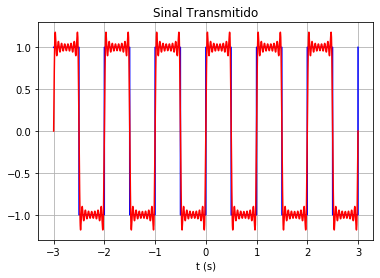

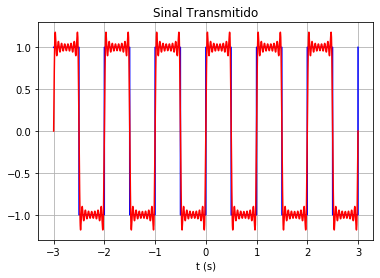

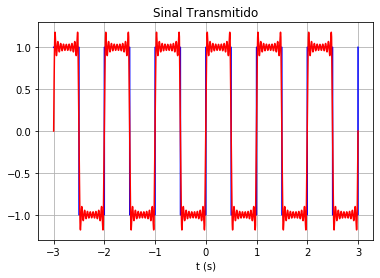

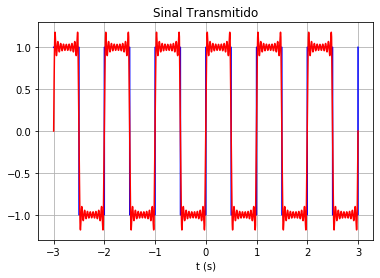

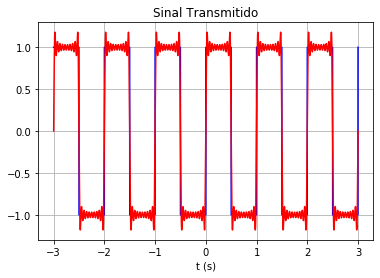

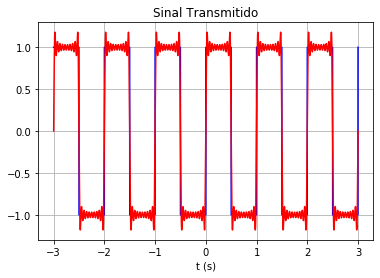

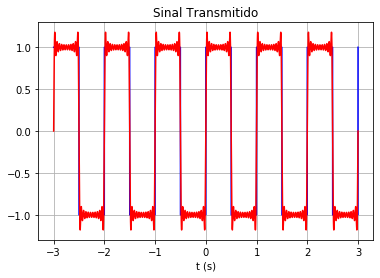

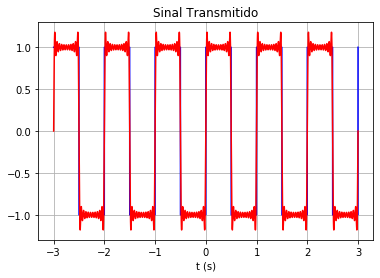

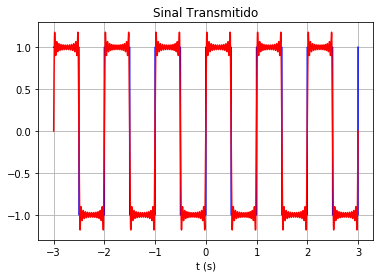

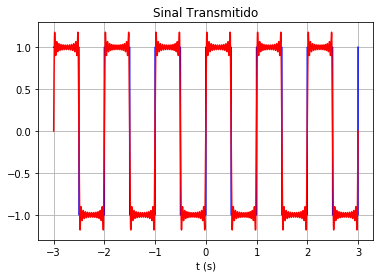

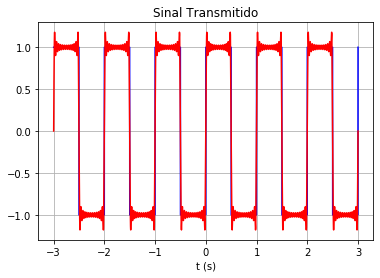

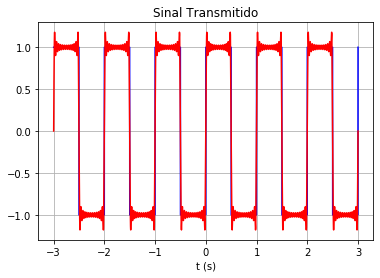

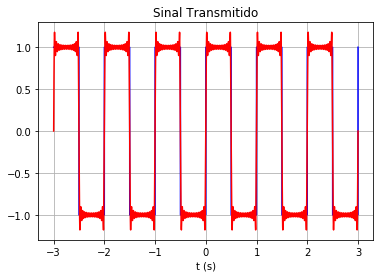

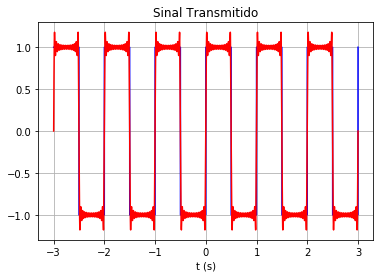

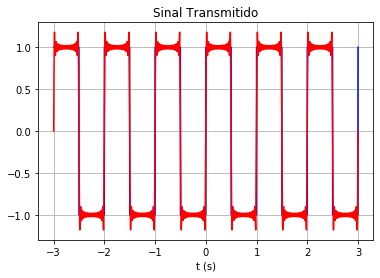

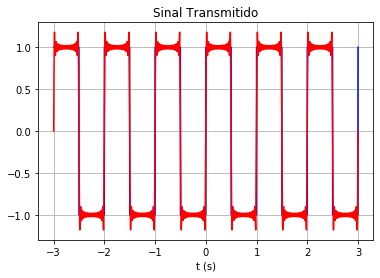

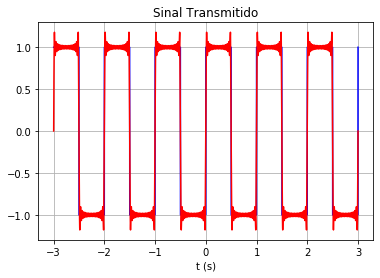

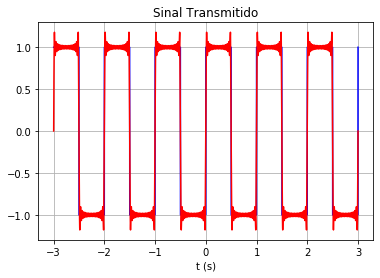

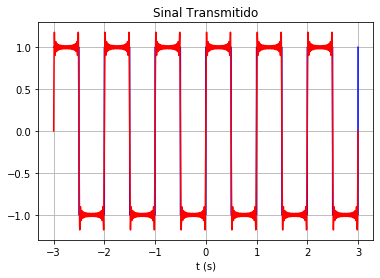

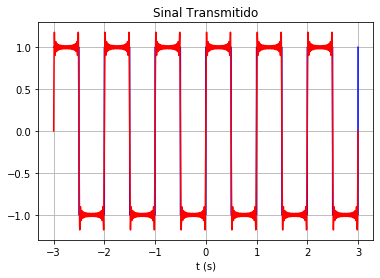

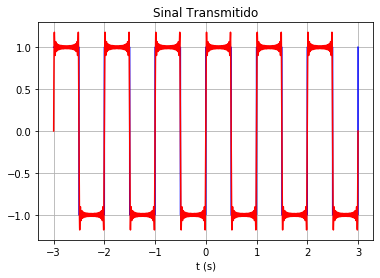

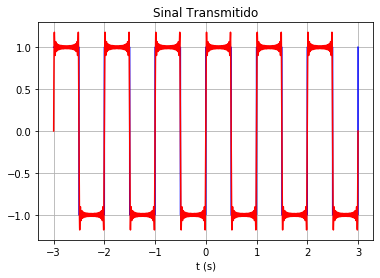

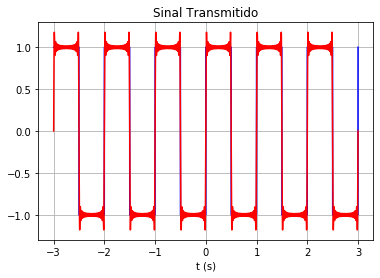

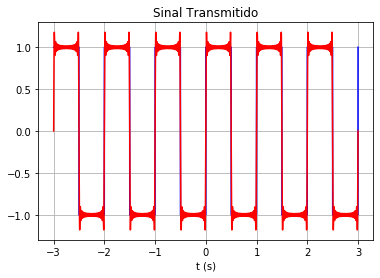

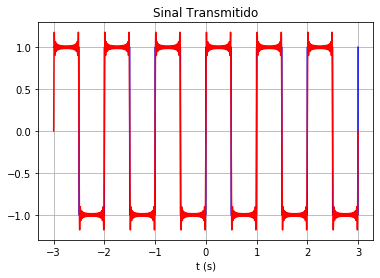

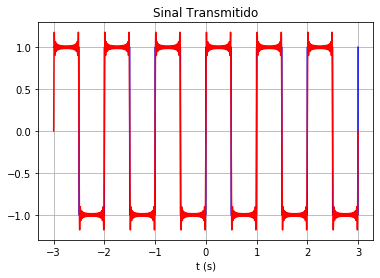

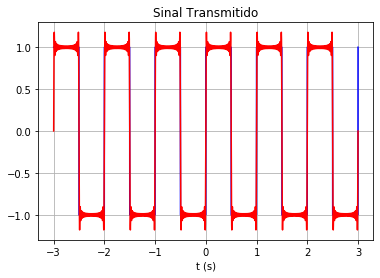

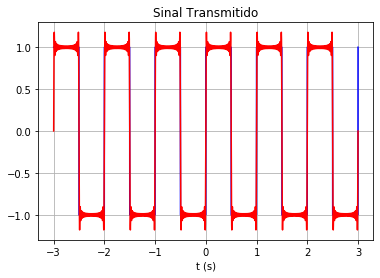

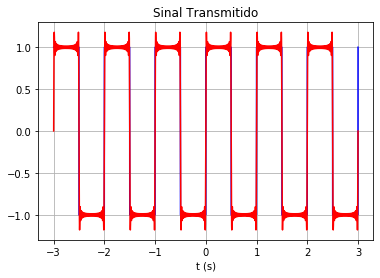

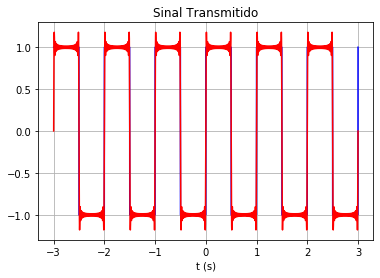

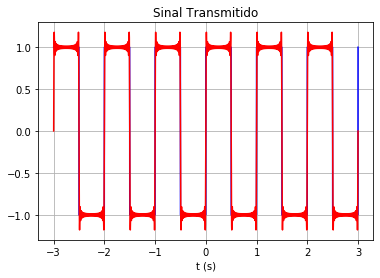

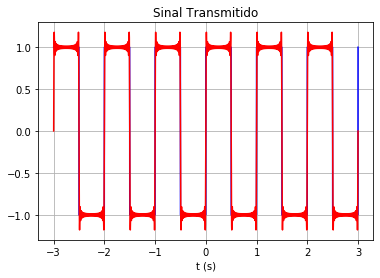

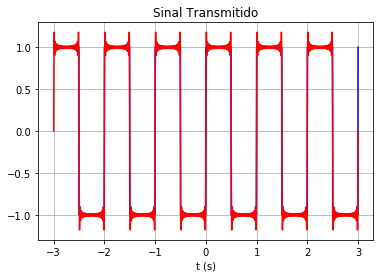

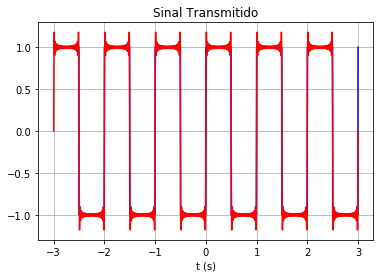

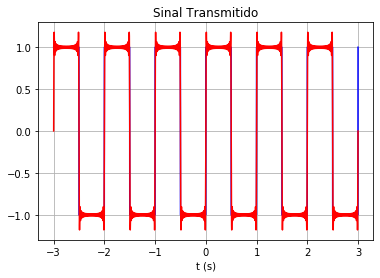

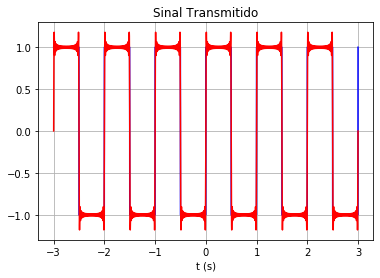

In [11]:
x_fourier = np.zeros(len(t))

a0 = 0

N = 50

vetor_An = np.zeros(N)
vetor_phi_n = np.zeros(N)

for n in range(1,N+1):
    if n%2 == 0:
        An = 0
        phi_n = 0
    else:
        An = 4/(np.pi*n)
        phi_n = -np.pi/2
    vetor_An[n-1] = An
    vetor_phi_n[n-1] = phi_n
    x_fourier = x_fourier + An*np.cos(2*np.pi*n*f0*t + phi_n)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(t, x,'-b')
    plt.plot(t, x_fourier,'-r')
    plt.title('Sinal Transmitido')
    plt.xlabel('t (s)')
    plt.grid()




Podemos, a partir daí, analisar o espectro do sinal de entrada. Fazendo o gráfico da amplitude e da fase de cada componente do nosso sinal, obtemos:

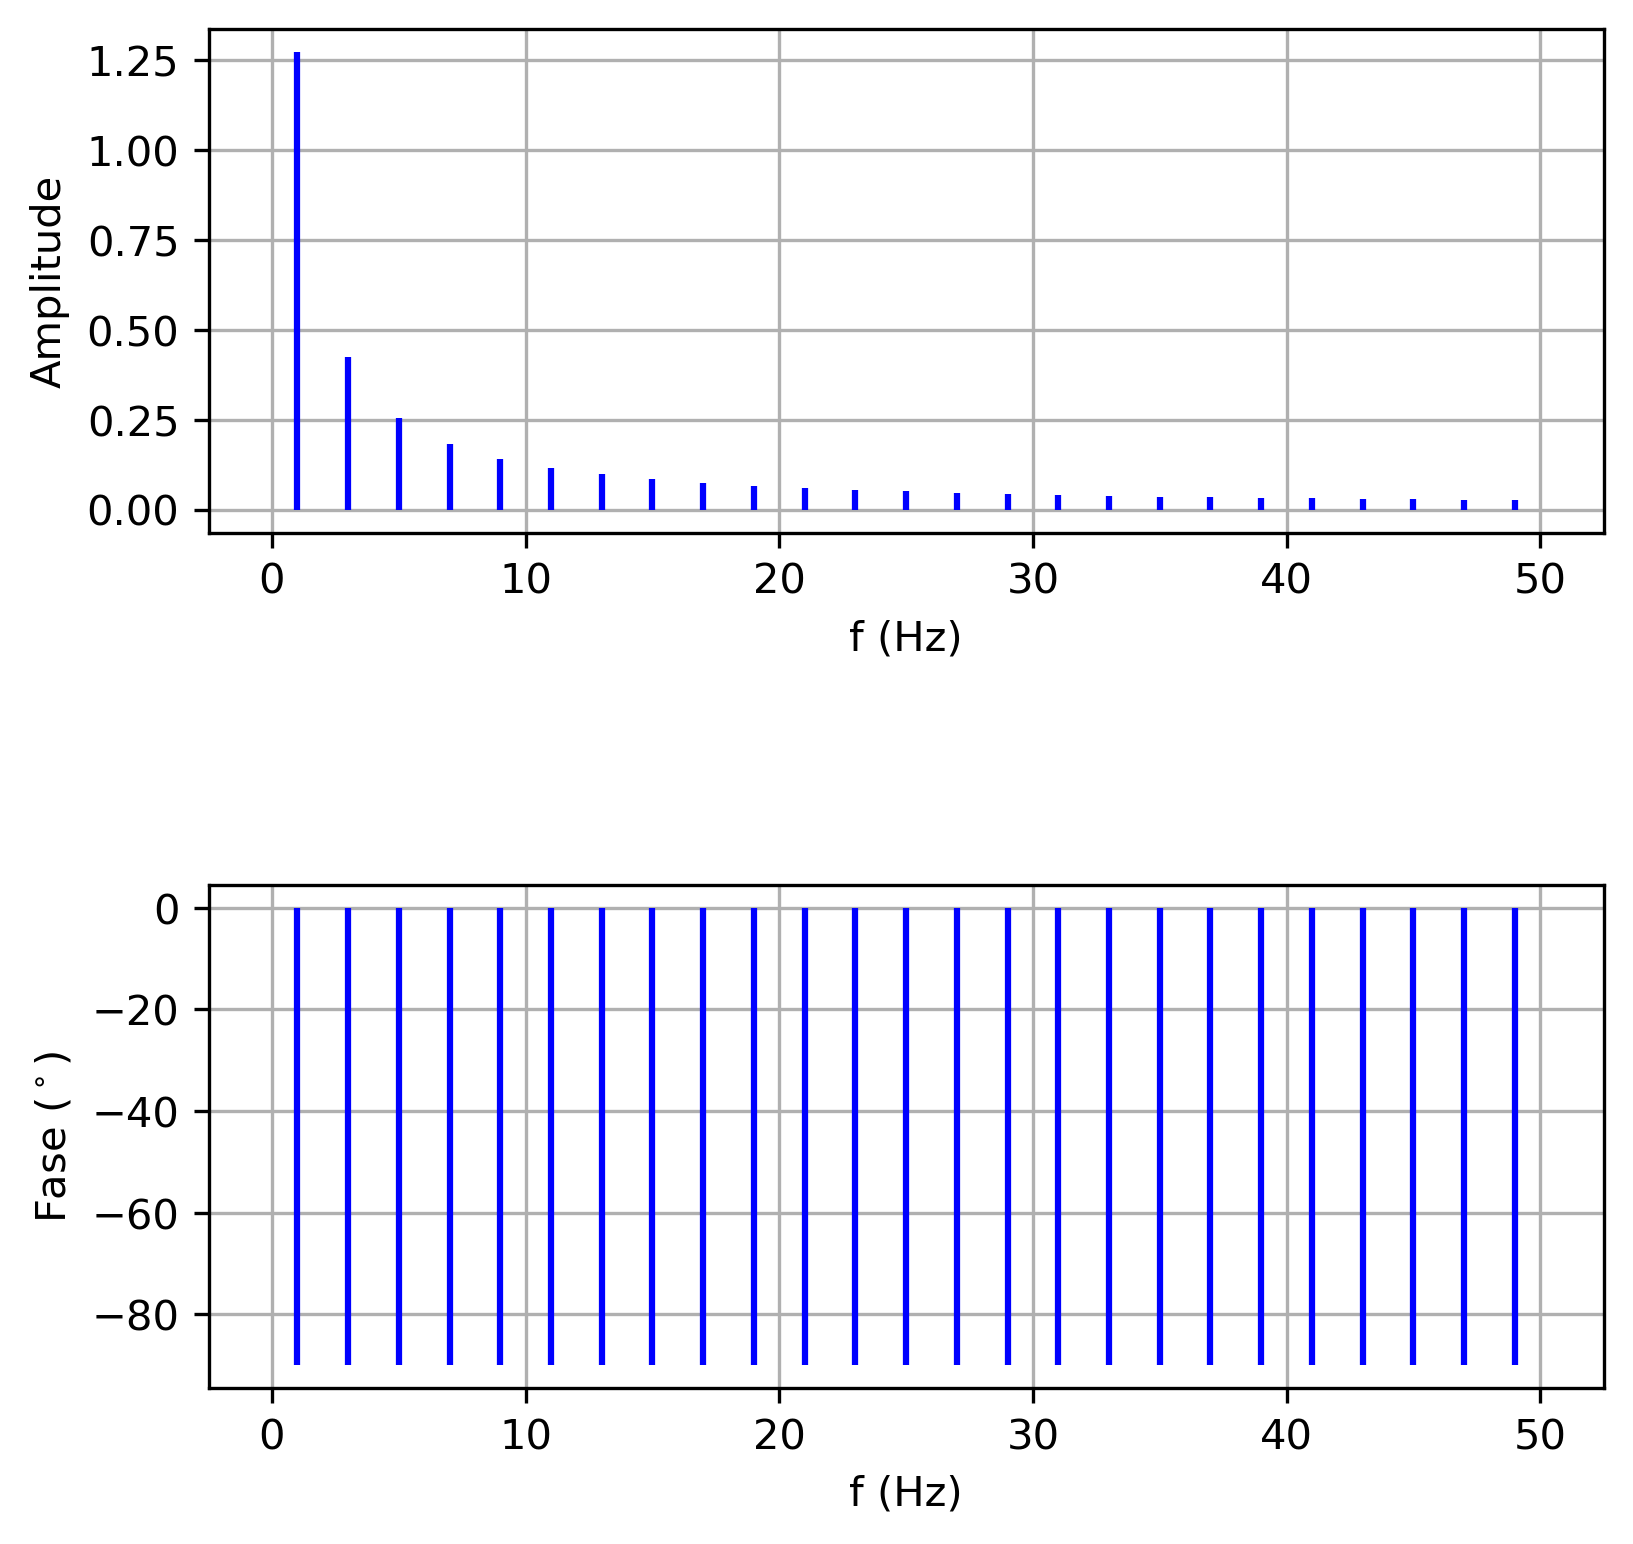

In [12]:
f1 = np.arange(f_final+1)

fig = plt.figure(figsize=(6,6), dpi= 300)
ax1 = fig.add_subplot(2, 1, 1)
(markerline, stemlines, baseline) = ax1.stem(f1, np.concatenate((np.asarray([a0]), vetor_An)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Amplitude')
plt.xlabel('f (Hz)')
plt.grid()
ax2 = fig.add_subplot(2, 1, 2)
(markerline, stemlines, baseline) = ax2.stem(f1, (180/np.pi)*np.concatenate((np.asarray([0]), vetor_phi_n)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Fase ($^\circ$)')
plt.xlabel('f (Hz)')
plt.grid()
fig.subplots_adjust(hspace=0.7)

O que acontece quando tentamos transmitir cada uma dessas componentes pelo canal de comunicação? Neste ponto, é importante lembrar que:

- A amplitude de cada componente senoidal do nosso sinal será **multiplicada** pelo módulo da resposta em frequência do canal
- A fase de cada componente senoidal do nosso sinal será **somada** à fase da resposta em frequência do canal

Com base nisso, podemos calcular a amplitude e a fase de cada componente do sinal de saída e plotar o seu espectro. Considerando as $N = 50$ primeiras harmônicas, temos:

In [16]:
# Cálculo da amplitude e da fase de cada harmônica que compõe o sinal de saíad:

fc1 = 2

N = 50

a0_saida = a0*modulo_resposta_em_frequencia(0,fc1)
vetor_An_sinal_de_saida = np.zeros(N)
vetor_phi_n_sinal_de_saida = np.zeros(N)

for n in range(1,N+1):
    if n%2 == 0:
        An_entrada = 0
        phi_n_entrada = 0
    else:
        An_entrada = 4/(np.pi*n)
        phi_n_entrada = -np.pi/2
        vetor_phi_n_sinal_de_saida[n-1] = phi_n_entrada + fase_resposta_em_frequencia(n*f0,fc1)
    vetor_An_sinal_de_saida[n-1] = An_entrada*modulo_resposta_em_frequencia(n*f0,fc1)
    

Plotando o resultado:

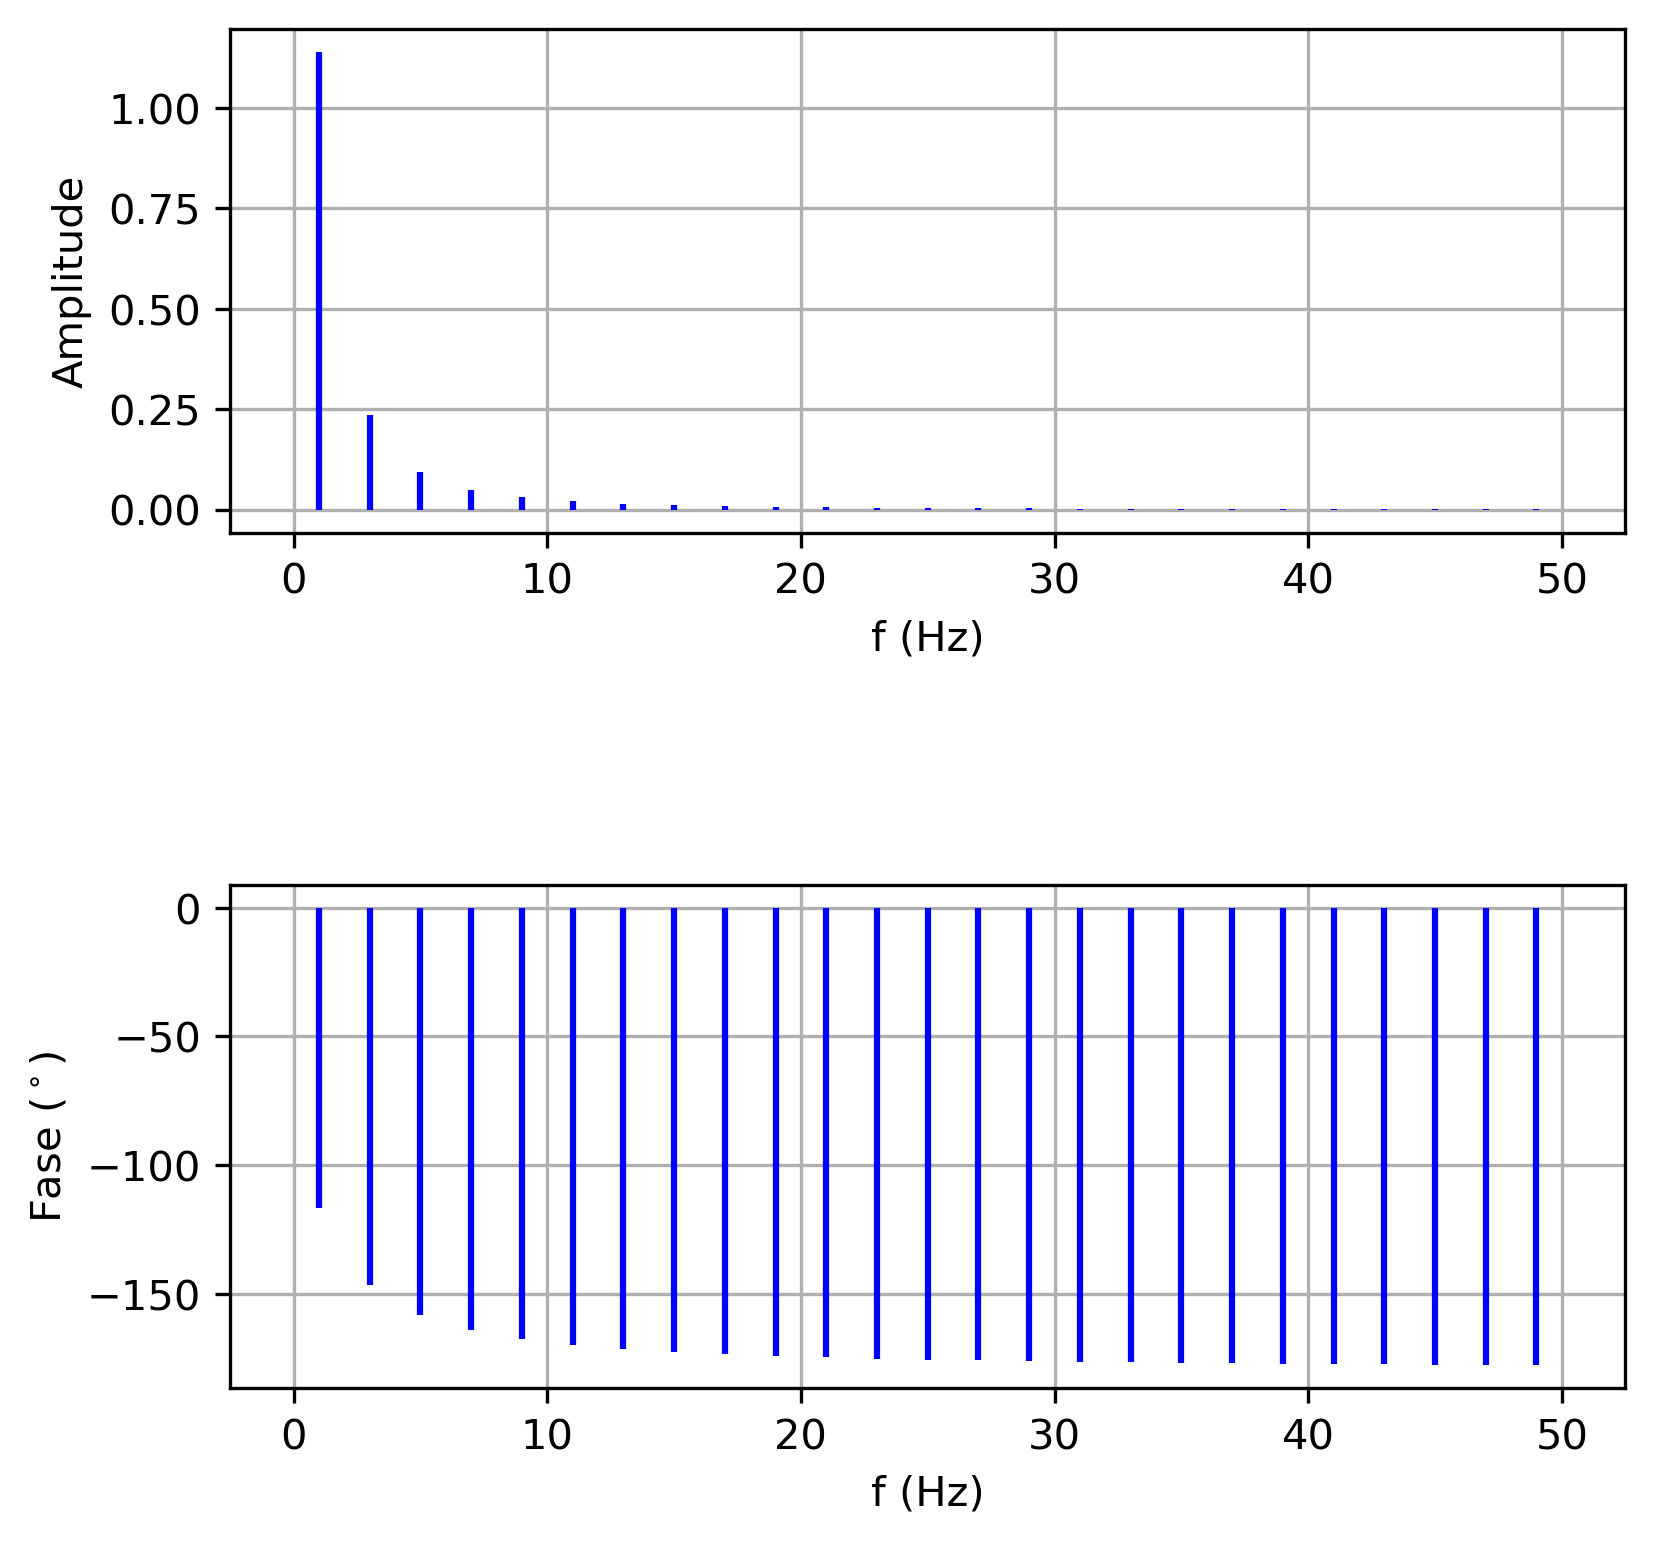

In [17]:
f1 = np.arange(f_final+1)

fig = plt.figure(figsize=(6,6), dpi= 300)
ax1 = fig.add_subplot(2, 1, 1)
(markerline, stemlines, baseline) = ax1.stem(f1, np.concatenate((np.asarray([a0_saida]), vetor_An_sinal_de_saida)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Amplitude')
plt.xlabel('f (Hz)')
plt.grid()
ax2 = fig.add_subplot(2, 1, 2)
(markerline, stemlines, baseline) = ax2.stem(f1, (180/np.pi)*np.concatenate((np.asarray([0]), vetor_phi_n_sinal_de_saida)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Fase ($^\circ$)')
plt.xlabel('f (Hz)')
plt.grid()

fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.7)

Note que o espectro do sinal recebido é **diferente** daquele do sinal emitido, pois o canal está atenuando mais fortemente as componentes com frequência comparativamente mais elevadas. A seguir, os dois espectros são mostrados lado a lado para efeito de comparação.

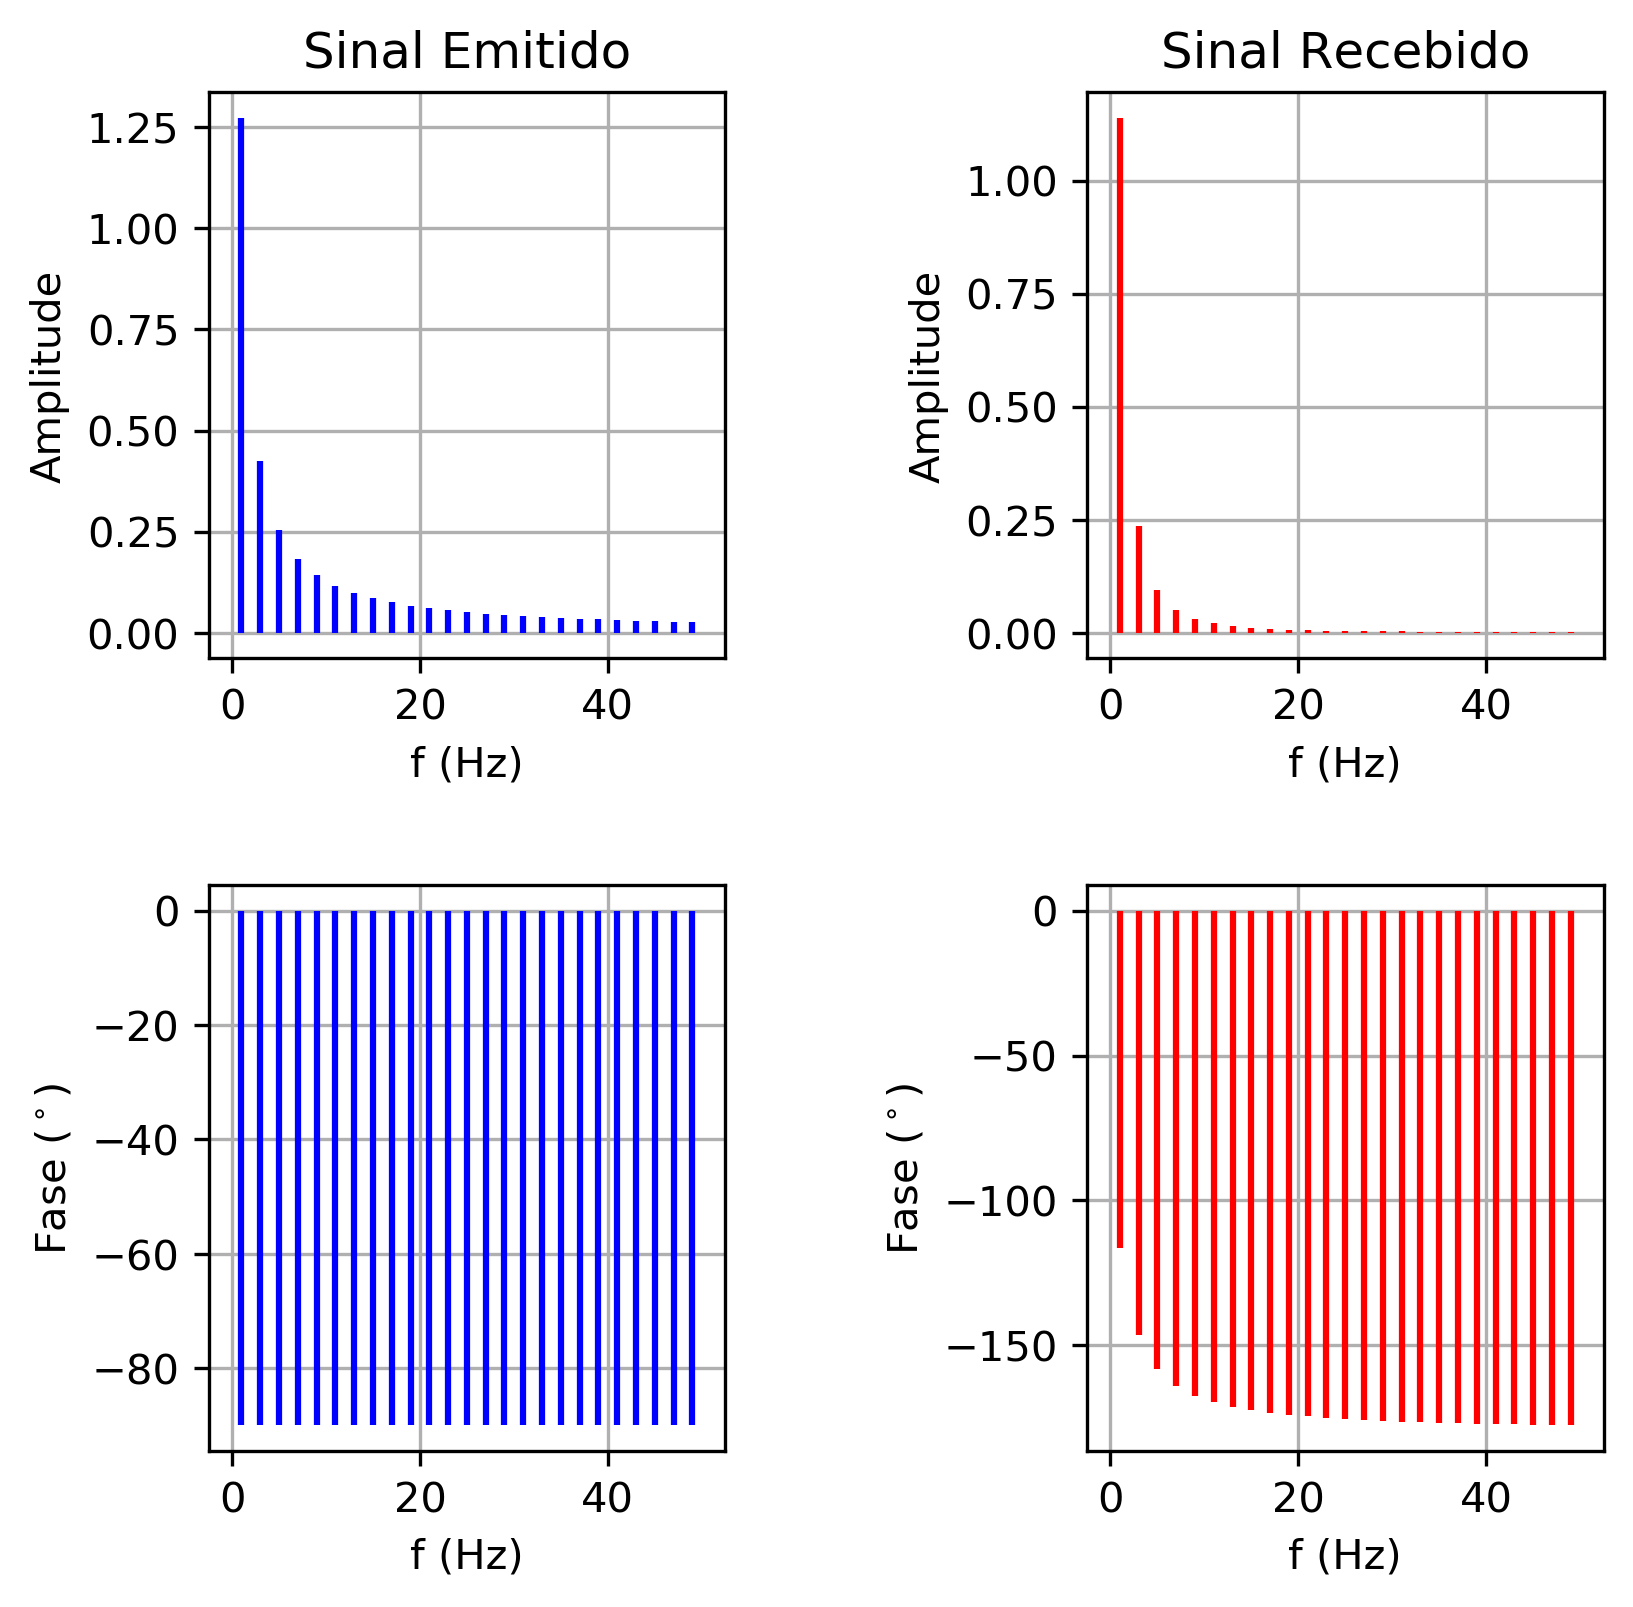

In [18]:
f1 = np.arange(f_final+1)

fig = plt.figure(figsize=(6,6), dpi= 300)
ax1 = fig.add_subplot(2, 2, 1)
(markerline, stemlines, baseline) = ax1.stem(f1, np.concatenate((np.asarray([a0]), vetor_An)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Amplitude')
plt.xlabel('f (Hz)')
plt.grid()
plt.title('Sinal Emitido')
ax2 = fig.add_subplot(2, 2, 3)
(markerline, stemlines, baseline) = ax2.stem(f1, (180/np.pi)*np.concatenate((np.asarray([0]), vetor_phi_n)),'-b', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Fase ($^\circ$)')
plt.xlabel('f (Hz)')
plt.grid()
ax3 = fig.add_subplot(2, 2, 2)
(markerline, stemlines, baseline) = ax3.stem(f1, np.concatenate((np.asarray([a0_saida]), vetor_An_sinal_de_saida)),'-r', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Amplitude')
plt.xlabel('f (Hz)')
plt.grid()
plt.title('Sinal Recebido')
ax4 = fig.add_subplot(2, 2, 4)
(markerline, stemlines, baseline) = ax4.stem(f1, (180/np.pi)*np.concatenate((np.asarray([0]), vetor_phi_n_sinal_de_saida)),'-r', markerfmt=" ", use_line_collection = True)
plt.setp(baseline, visible=False) 
plt.ylabel('Fase ($^\circ$)')
plt.xlabel('f (Hz)')
plt.grid()

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.7)

### Assim como o sinal emitido é o somatório das várias ondas senoidais que encontramos utilizando a Análise de Fourier, o sinao recebido é o somatório das várias ondas senoidais que encontramos agora há pouco, cada uma afetada de uma determinada maneira pelo canal de comunicação###

Em geral, para procurar compreender o efeito de um canal, considerar apenas até a terceira harmônica não é suficiente. Vamos reproduzir o cálculo acima, mas agora considerando as 50 primeiras harmônicas:

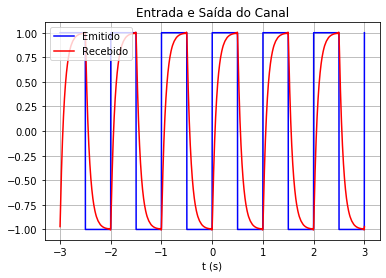

In [19]:
a0 = 0

fc1 = 2

f0 = 1



y1 = a0_saida*np.ones(len(t))

N = 50

for n in range(1,N+1):
    y1 = y1 + vetor_An_sinal_de_saida[n-1]*np.cos(2*np.pi*n*f0*t + vetor_phi_n_sinal_de_saida[n-1])

    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot1, = plt.plot(t, x,'-b')
plot2, = plt.plot(t, y1,'-r')
plt.title('Entrada e Saída do Canal')
plt.legend([plot1,plot2],["Emitido", "Recebido"], loc = 'upper left')
plt.xlabel('t (s)')
plt.grid()

Note que o sinal recebido é claramente distinto do emitido. Como estamos tentando transmitir o sinal azul por um canal **passa-baixas**, as variações mais rápidas do sinal (associada às componentes de alta frequência) tendem a ser **suavizadas**